In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from matplotlib_venn import venn2

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, show_pathways_in_ranked_genes, add_pathways_to_deseq_df
from dokdonia.utils import terminal_execute, saveToPickleFile, compute_replicate_averages, merge_two_conditions

# plt.style.use('plt_styles.mplstyle')
%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

## Obtain functional annotations

In [2]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 786 genes


# Load count data

In [3]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

index  D_10_R1  D_10_R2  D_10_R3  D_18_R1  D_18_R2  D_18_R3  \
0  MED134_07389    12973    11426    13251    30624    30618    41014   
1  MED134_07384     1557     1555     1552     4160     4385     5588   
2  MED134_07379     3400     3319     3273     7218     7903     9539   
3  MED134_07374     1987     2124     1404     3509     3772     4337   
4  MED134_07369     2087     2010     2111     3774     3809     4486   

   D_18_R4  D_25_R1  D_25_R2  ...  L_18_R2  L_18_R3  L_18_R4  L_25_R1  \
0    22449    53840    32369  ...    16255    23945    20102    39444   
1     2940     7550     4509  ...     2564     3003     2894     5419   
2     5040    13268     7572  ...     4575     5361     4923     9089   
3     2602     4607     3316  ...     1798     2558     2637     3586   
4     2901     4668     3456  ...     2545     3456     3008     3705   

   L_25_R2  L_25_R3  L_34_R1  L_34_R2  L_34_R3  L_34_R4  
0    41721    37020    39662    30983    27280    57834  
1     5536     5318     5396     4751     4285     7818  
2     9016     8529    10179     7617     7207    13827  
3     3594     3488     4158     3096     2623     5323  
4     4158     3760     5518     3563     2713     5150  

[5 rows x 29 columns]

In [ ]:
# TPM-normalize count data
patric_file = pd.read_csv(data_dir / "Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv")
tpm = DE.tpmNormalize(counts, patric_file).set_index("index")
tpm.to_csv(data_dir / "tpm_counts.csv")

# Find DE genes between Light and Dark

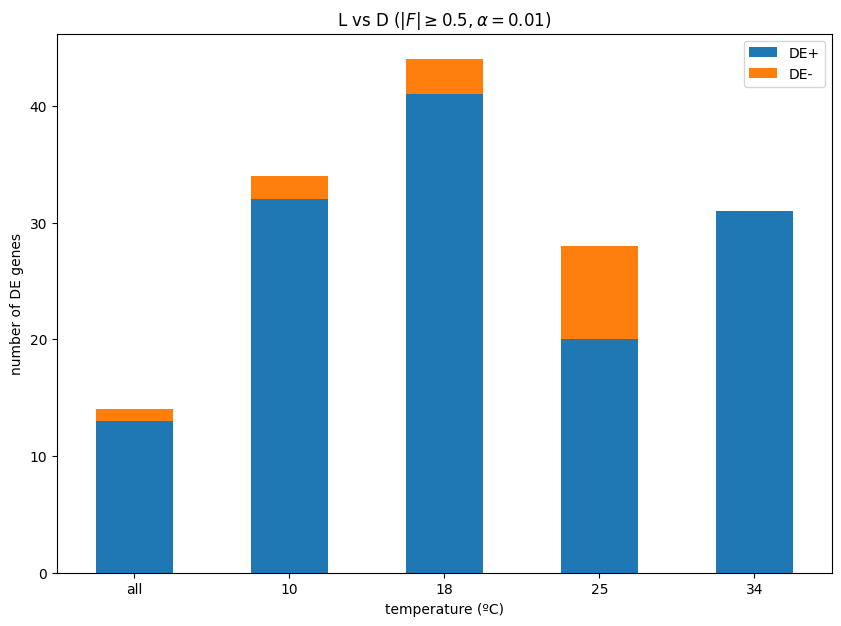

In [4]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

ax.get_figure().savefig(results_dir / "figures" / "DE_L_D_across_temperatures.eps", dpi=300)

In [5]:
ax.get_figure().savefig(results_dir / "figures" / "DE_L_D_across_temperatures.eps", dpi=300)

In [6]:
L_D_stats['18']

{'DE+': 41, 'DE-': 3}

We find DE genes, with a absolute fold cutoff value $|K|\geq0.5$ and significance level $\alpha=0.01$ across all temperatures. In all cases, there are more genes with greater expression under light than those with greater expression in the dark.

Let's look at the lists of DE genes across  temperatures:

In [7]:
# L > D, T = 18 Proteins [Sale alguno en cluster?]
from functools import reduce


DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }


# Find intersections
data_L_D = [DELD[T]["L>D"][["product", "subsystem", "system"]] for T in ['10', '18', '25', '34']]
df_merged_L_D = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_L_D)
# Remove duplicated cols
df_merged_L_D = df_merged_L_D[["product_x", "subsystem_x", "system_x"]]
df_merged_L_D = df_merged_L_D.loc[:, ~df_merged_L_D.columns.duplicated()]
# D - L
data_D_L = [DELD[T]["D>L"][["product", "subsystem", "system"]] for T in ['10', '18', '25', '34']]
df_merged_D_L = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_D_L)
# Remove duplicated cols
df_merged_D_L = df_merged_D_L[["product_x", "subsystem_x", "system_x"]]
df_merged_D_L = df_merged_D_L.loc[:, ~df_merged_D_L.columns.duplicated()]

# Write to Excel
excel_out = results_dir / "deseq_results" / "light_dark_deseq2.xlsx"
with pd.ExcelWriter(excel_out) as writer:  
    for temp, cond_res in DELD.items():
        for cond, df in cond_res.items():
            if "value" in df.columns:
                df = df.rename({"value": "log2FoldChange"}, axis=1)
            df.to_excel(writer, sheet_name=f"{temp}_{cond}")


    df_merged_L_D.to_excel(writer, sheet_name="common_genes_L>D")
    df_merged_D_L.to_excel(writer, sheet_name="common_genes_D>L")

DELD['18']["L>D"].head()

/tmp/ipykernel_30974/2827890644.py:25: FutureWarning: Passing 'suffixes' which cause duplicate columns {'product_x', 'subsystem_x', 'system_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_L_D = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_L_D)
/tmp/ipykernel_30974/2827890644.py:31: FutureWarning: Passing 'suffixes' which cause duplicate columns {'product_x', 'subsystem_x', 'system_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged_D_L = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_D_L)


baseMean  log2FoldChange     lfcSE       stat        pvalue  \
gene_id                                                                        
MED134_04999   263.884354        1.785131  0.217448   8.209451  2.222013e-16   
MED134_07119  1363.286304        1.726923  0.094093  18.353382  3.101890e-75   
MED134_10396  1405.063321        1.657843  0.103206  16.063371  4.608120e-58   
MED134_04009  1408.019749        1.577138  0.088560  17.808788  6.040379e-71   
MED134_07089   392.184936        1.394440  0.125108  11.145931  7.495620e-29   

                      padj                          product    subsystem  \
gene_id                                                                    
MED134_04999  2.912851e-14   putative cell adhesion protein  Unspecified   
MED134_07119  8.924138e-72                        rhodopsin  Unspecified   
MED134_10396  4.419187e-55             hypothetical protein  Unspecified   
MED134_04009  8.689085e-68  ATP-dependent protease La (LON)  Unspecified   
MED134_07089  1.797075e-26   sensor of blue-light using FAD  Unspecified   

                   system  
gene_id                    
MED134_04999  Unspecified  
MED134_07119  Unspecified  
MED134_10396  Unspecified  
MED134_04009  Unspecified  
MED134_07089  Unspecified

# Effect of temperature on L-D DE genes
How do DE genes across light and dark behave across temperatures?

In [8]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


In [9]:
# Get transcript/cell dataset
TC = pd.read_csv(data_dir / 'Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC = TC.set_index('index')
TC.index.name = 'ID'

# Compute averages
light, dark = compute_replicate_averages(TC)
concat_light_dark = pd.concat([light, dark], axis=1)
merged_light_dark = merge_two_conditions(concat_light_dark)

concat_light_dark.to_excel(results_dir / "transcripts" / "mean_across_replicates.xlsx")
merged_light_dark.to_excel(results_dir / "transcripts" / "mean_across_temperatures.xlsx")

## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

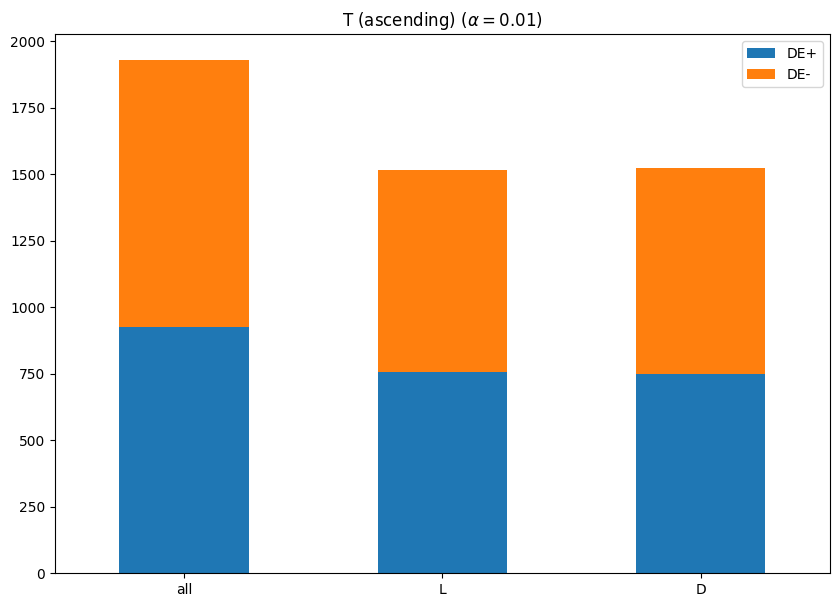

In [10]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

saveToPickleFile(T_res, results_dir / "deseq_results" / "DE_result.pkl")

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [11]:
# Write to excel, add pathways
excel_out = results_dir /"deseq_results" / "across_temperature_deseq2.xlsx"
with pd.ExcelWriter(excel_out) as writer:

    for cond, res in T_res.items():
        res = add_pathways_to_deseq_df(
            res,
            gbk,
            gene_pathways,
            gene_systems
            ).drop("log2FoldChange", axis=1)
        res.to_excel(writer, sheet_name=f"{cond}")

In [12]:
# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

There are 1930 out of 2877 genes which are DE across all temperature values


In [13]:
# # Plot L-D Venn diagram
# from matplotlib_venn import venn2

# plt.figure(figsize=(8, 8))
# set1 = set(T_res['L'].index)
# set2 = set(T_res['D'].index)
# Light_specific_DE_genes = set1 - set2
# Dark_specific_DE_genes = set2 - set1
# venn2([set1, set2], ('L', 'D'),
#       set_colors=('purple', 'skyblue'), alpha = 0.7)
# plt.title('DE genes across T (L vs D)')
# plt.show()

# Effect of temperature on gene expression: Pathway enrichment analysis

Next, we analyze the effect that temperature may have on gene expression. To this end, we first cluster genes according to their across-temperature expression pattern, and then perform a permutation-based pathway enrichment analysis to evaluate which pathways are most affected by temperature changes.

To separate the effect of light and dark from that of temperature, we leave out of the analysis the set of genes that were DE between light and dark.

In [13]:
# Remove light-dark DE genes from dataset
TCnoDE = TC.loc[(
    (~TC.index.isin(DE_all_T)) &
    (TC.index.isin(DE_genes_across_T))
    )]

print(f"Number of genes to cluster: {len(TCnoDE)}")

Number of genes to cluster: 1925


# Table of genes which are not affected by temperature

In [14]:
TC_temperature_independent = TC.loc[(
    ~TC.index.isin(DE_genes_across_T)
)]

ranked_series = TC_temperature_independent.median(axis=1).sort_values(ascending=False)
ranked_df = show_pathways_in_ranked_genes(
    ranked_series.to_dict(),
    gbk, gene_pathways,
    gene_systems, n=None
    )

ranked_out_csv = results_dir / "results_temperature_independent" / "temp_independent_genes_avg_expression.csv"
ranked_out_xlsx = results_dir / "results_temperature_independent" / "temp_independent_genes_avg_expression.xlsx"
ranked_df.to_csv(ranked_out_csv)
ranked_df.to_excel(ranked_out_xlsx)

print(f"Number of genes not affected by temperature: {len(TC_temperature_independent)}")


Number of genes not affected by temperature: 947


# Light-Dark DE genes which are also DE across Temperatures (wald + LTR)

In [15]:
DE_D_L_and_across_T = [gene_id for gene_id in DE_all_T if gene_id in DE_genes_across_T]
DE_D_L_and_across_T

['MED134_03404',
 'MED134_10201',
 'MED134_13071',
 'MED134_13076',
 'MED134_14266']

In [16]:
temperatures = [10, 18, 25, 34]
conditions = ["L", "D"]
df = TC.loc[DE_D_L_and_across_T, :]

data = {}
for condition in conditions:
    data[condition] = []
    for temp in temperatures:
        colpattern = f"{condition}_{temp}"
        series = df.loc[:, [col for col in df.columns if colpattern in col]].mean(axis=1)
        series.name = colpattern
        data[condition].append(
            series
            )

dark_df = pd.DataFrame(data["D"])
light_df = pd.DataFrame(data["L"])
excel_out = results_dir / "results_DE_L_D_and_across_T" / "DE_L_D_and_across_T_transcript_cell.xlsx"
with pd.ExcelWriter(excel_out) as writer:
    light_df.transpose().to_excel(writer, sheet_name="light")
    dark_df.transpose().to_excel(writer, sheet_name="dark")

<AxesSubplot: >

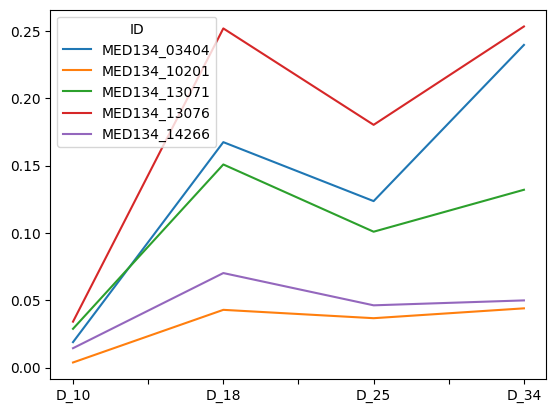

In [17]:
dark_df.plot()

<AxesSubplot: >

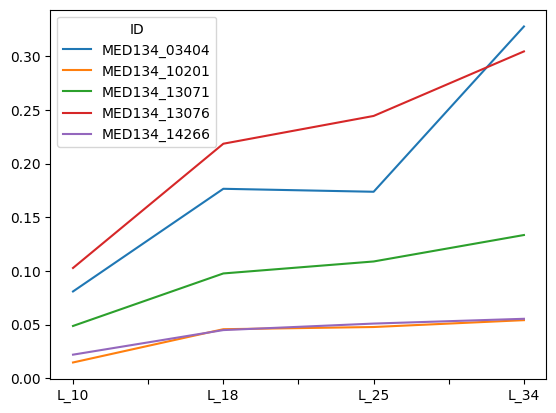

In [18]:
light_df.plot()

In [19]:
# Add pathways
ranked_df = show_pathways_in_ranked_genes(
    light_df.transpose().mean(axis=1).to_dict(),
    gbk, gene_pathways,
    gene_systems, n=None
    )
ranked_df.drop(
    "value", axis=1
    ).to_excel(
    results_dir / "results_DE_L_D_and_across_T" / "DE_L_D_and_acrosss_T.xlsx"
    )

## Cluster by gene expression pattern

Quantile normalization may be problematic since it can alter the trend.

"3: Quantile normalization. This step transforms the expression values in such a way that the distribution of expression values across samples becomes the same. Quantile normalization helps to correct for technical biases in the data, making it easier to compare gene expression values across different samples."

Perhaps repeat removing "3" from clust_input.tsv 101 3 4 in "clust_normalization.tsv"?

## USING TPM again to evaluate normalization

In [75]:
# Remove light-dark DE genes from dataset
tpm_noDE = tpm.loc[(
    (~tpm.index.isin(DE_all_T)) &
    (tpm.index.isin(DE_genes_across_T))
    )]

In [76]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TPM'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters = CA.getGeneClusters(tpm_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1e4)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 17 April 2023 (15:09:59)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

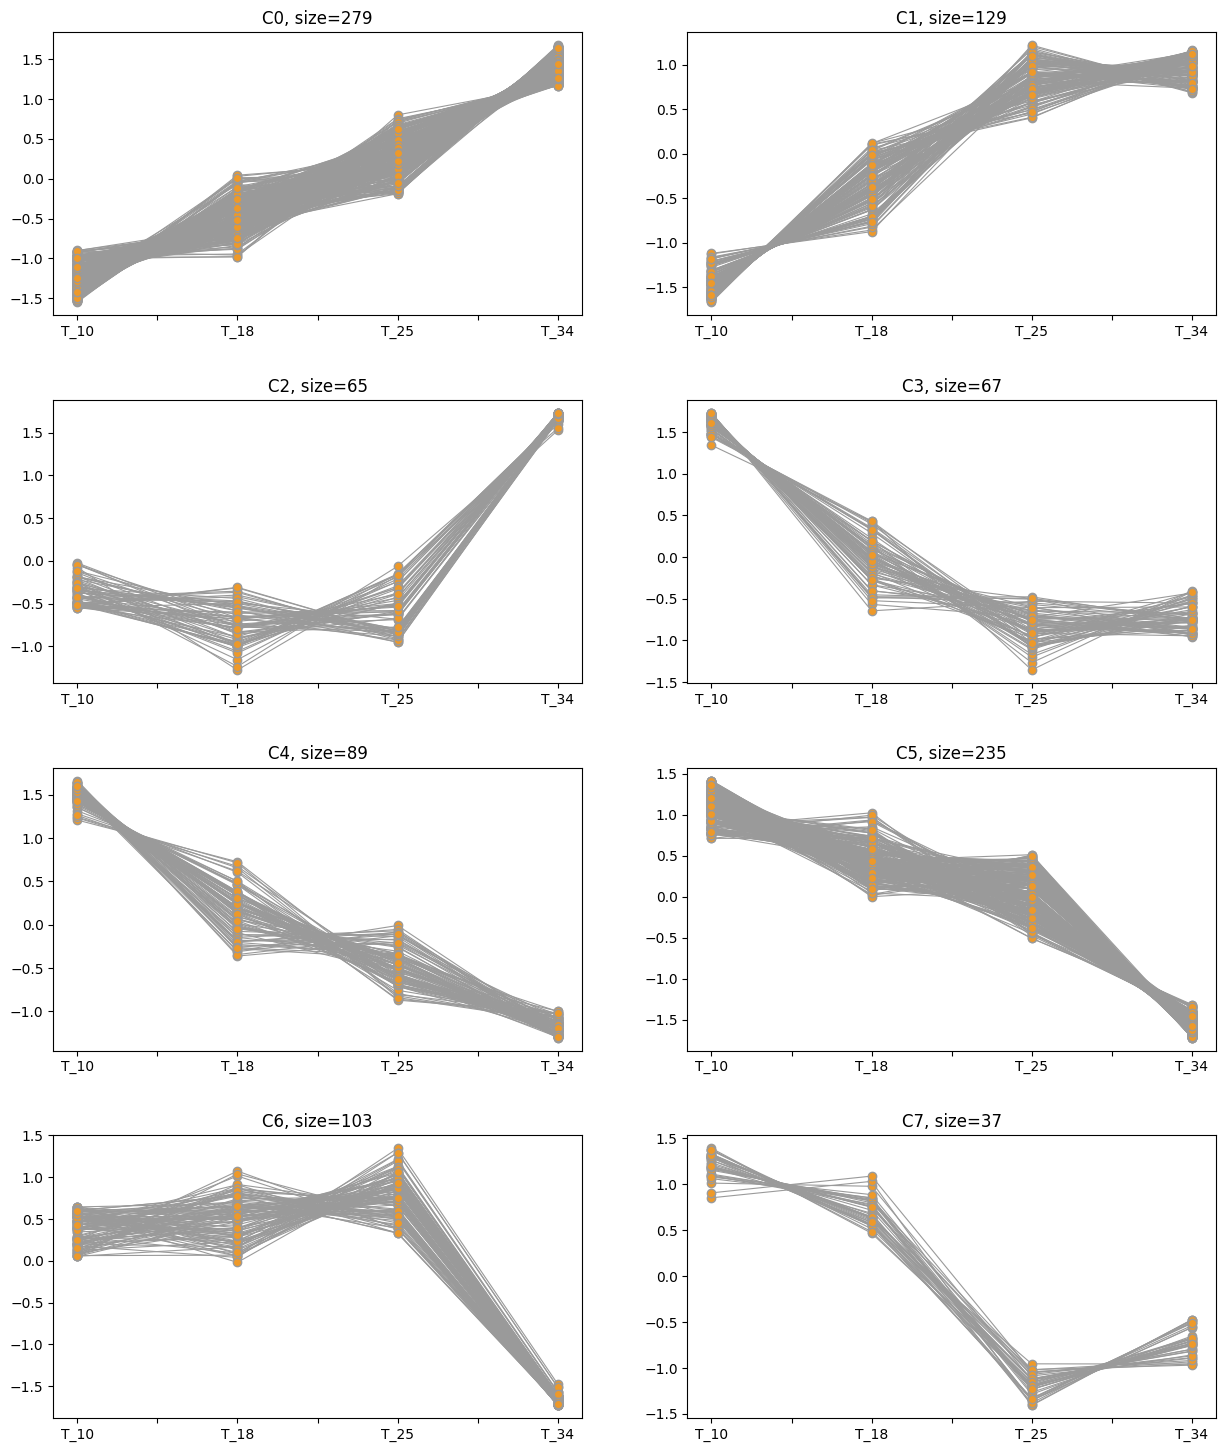

In [77]:
VI.plotClusters(plot_cluster_data, clusters)

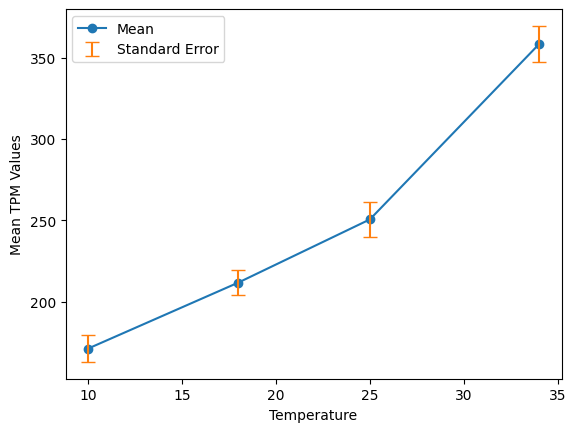

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


temperatures = [10, 18, 25, 34]
marker_genes = [gene for gene in clusters["C0"]]
df = tpm.loc[marker_genes, :]
# df = TC.loc[marker_genes, :]


df_long = df.melt(var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

grouped = df_long.groupby('Temperature')['Value']
mean_values = grouped.mean()
standard_error_values = grouped.sem()


fig, ax = plt.subplots()

# Plot the mean values
ax.plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

# Add error bars for the standard errors
ax.errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Mean TPM Values')
# ax.set_title('Mean Values with Standard Error across Temperature Values')
ax.legend()

# Show the plot
plt.show()

## Interestingly

I get much better results when using TPMs. Gene patterns are conserved when removing the original normalization performed by Clust. This is not the case when using Transcript / Cell (which are already normalized but in a manner that I don't understand fully).

## Using Transcript / Cell

In [26]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1e2)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Monday 17 April 2023 (13:35:15)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

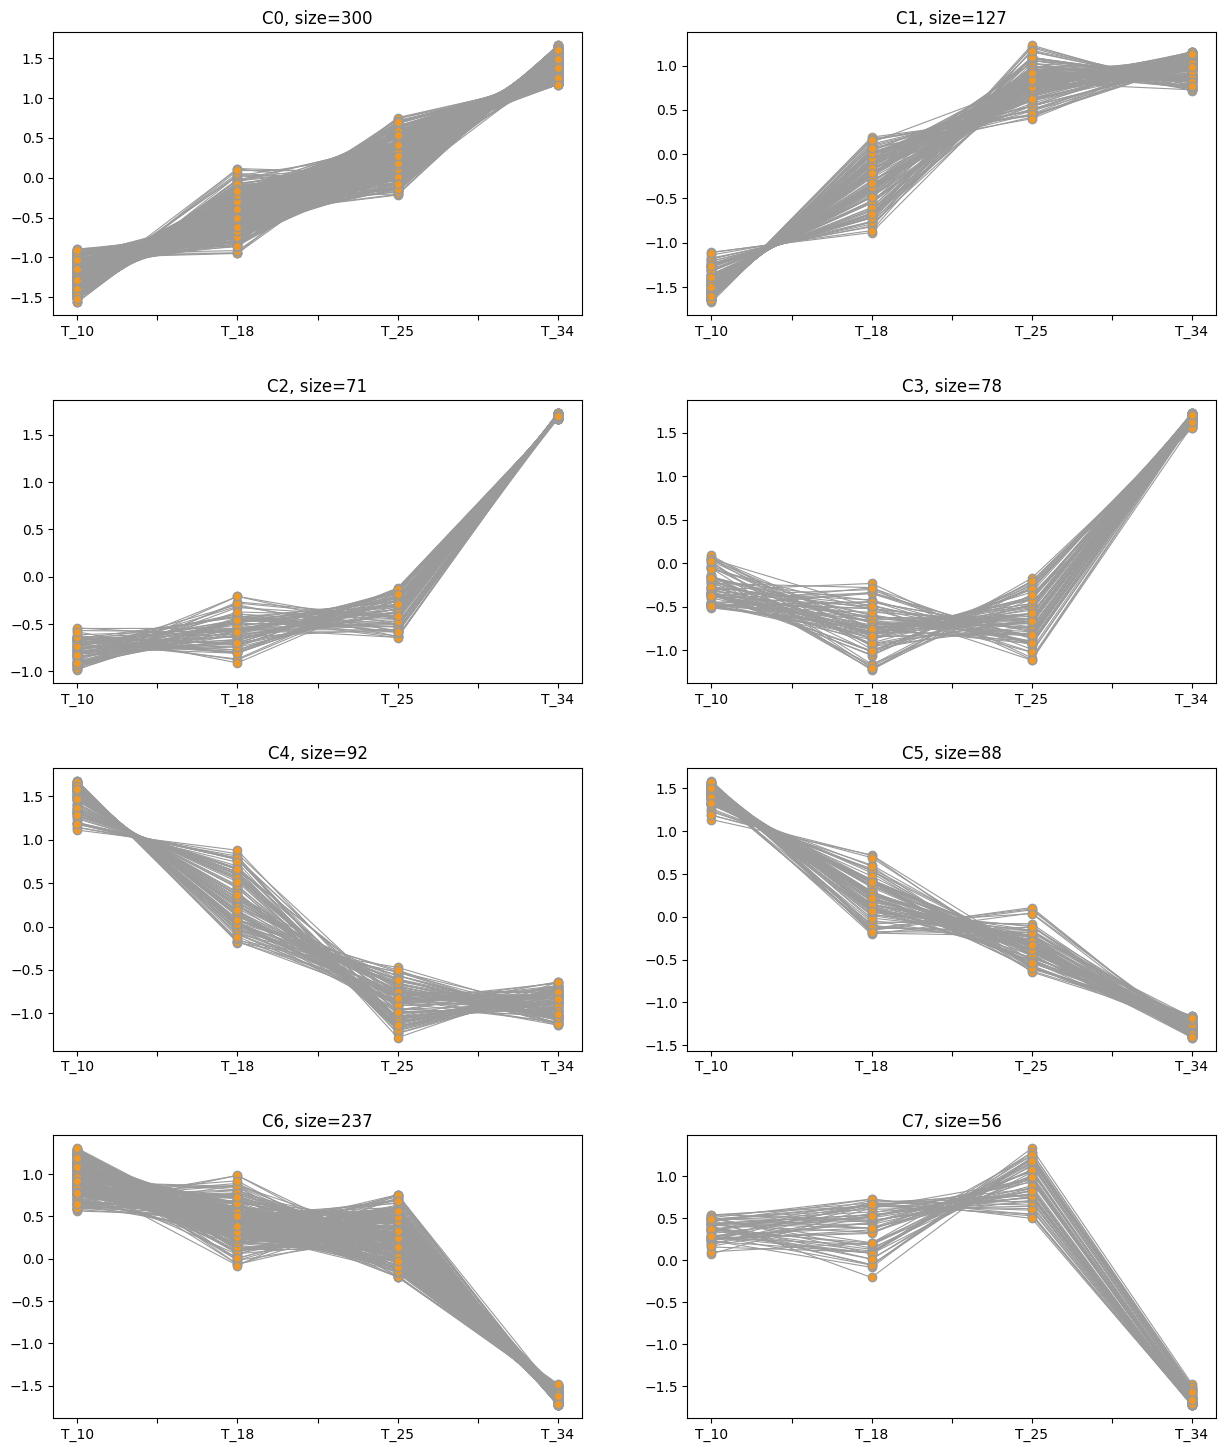

In [32]:
VI.plotClusters(plot_cluster_data, clusters)

# Merge clusters:

1. C2 & C3
2. C6 & C7

In [33]:
clusters = {
    "C0": clusters["C0"],
    "C1": clusters["C5"],
    "C2": clusters["C2"] + clusters["C3"],
    "C3": clusters["C6"] + clusters["C7"],
    "C4": clusters["C1"],
    "C5": clusters["C4"]
}

# Merge clusters in Clust output file
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in clusters.items() ]))
df = df.applymap(lambda x: "" if pd.isna(x) else x)

with open(results_dir / "clust" / f"{res_id}/Clusters_Objects_merged.tsv", "w+") as file:
    file.write("\t".join([f"{k} ({len(v)} genes)" for k,v in clusters.items()]) + "\n")
    file.write("\t".join(["Genes" for _ in clusters]) + "\n")

    for row in df.values:
        file.write("\t".join(row) + "\n")

n_genes_in_clusters = sum([len(c) for c in clusters.values()])
print(f"There are a total of {n_genes_in_clusters} clustered genes")

There are a total of 1049 clustered genes


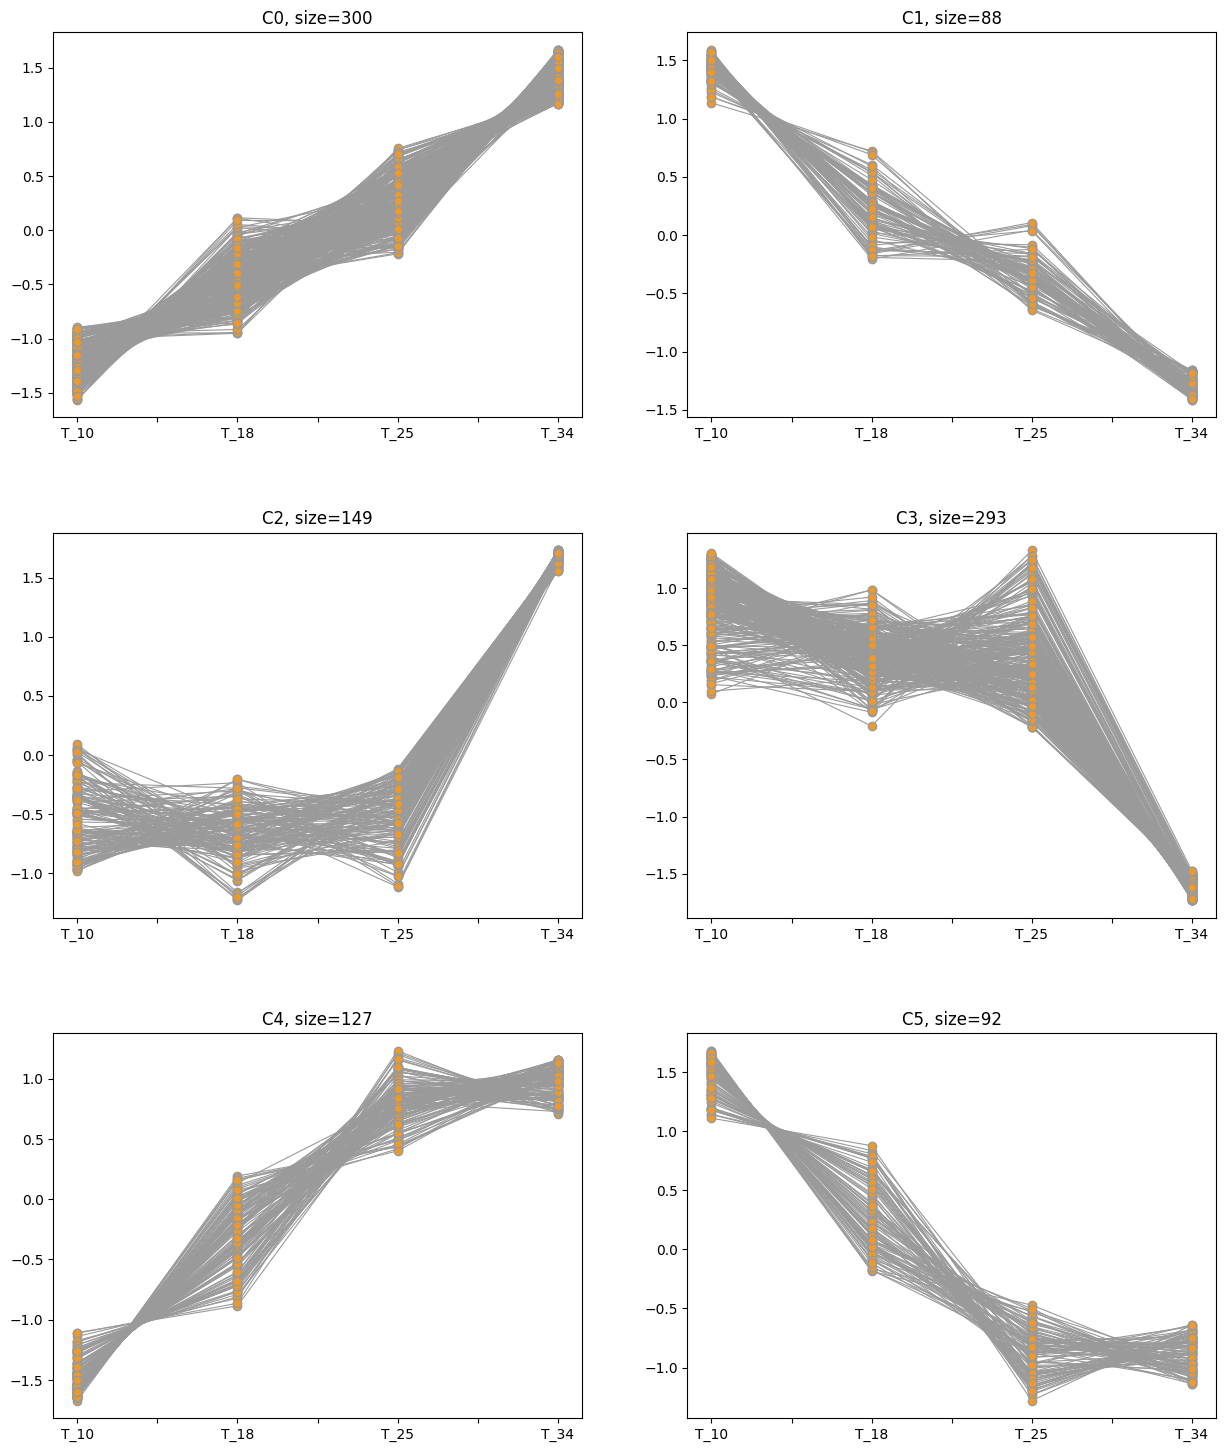

In [34]:
# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(), results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters, outfile=results_dir / "clust" / f"{res_id}/high_res_clusters.eps")

## Rank genes within clusters

Rank genes within clusters by ther silhouette

In [35]:
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
ranked_clusters = CA.rankGenesWithinClusters(clusters, cluster_data, method="sil")

cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Input_files_and_params/Data/clust_input.tsv'),
    sep='\t', index_col='ID').divide(1e4)
ranked_clusters_avg_expr = CA.rankGenesWithinClusters(clusters, cluster_data, method="median")

# Gene set enrichment with R

KEGG subsystems

In [26]:
out_dir = results_dir / "enrichment_results"
clusters_path = results_dir / "clust" / f"{res_id}" / "Clusters_Objects_merged.tsv"
stout = terminal_execute(
    command_str=(
    f"Rscript {root_dir / 'dokdonia' / 'clusterProfiler.R'}"
    f" {res_id} {clusters_path} {out_dir}"
    )
)


clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:stats’:

    filter

Warning message:
In compareCluster(geneClusters = cluster_genes, fun = "enrichKEGG",  :
  No enrichment found in any of gene cluster, please check your input...
Error in is.data.frame(x) : 
  trying to get slot "compareClusterResult" from an object of a basic class ("NULL") with no slots
Calls: write.csv ... eval.parent -> eval -> eval -> <Anonymous> -> is.data.frame
Execution halted


In [36]:
# Using R's library ClusterProfiler
df = pd.read_csv(results_dir / f"enrichment_results/results_{res_id}.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df = df.sort_values(["Cluster", "p.adjust"])
res_df = df[["Cluster", "ID", "Description", "GeneRatio", "pvalue", "p.adjust"]].set_index("Cluster")
res_df.to_csv(results_dir / "enrichment_results" / "cluster_pathways.csv")
res_df

ID                                   Description GeneRatio  \
Cluster                                                                     
C1       dok03018                               RNA degradation      3/17   
C2       dok00630       Glyoxylate and dicarboxylate metabolism      5/26   
C2       dok01120  Microbial metabolism in diverse environments      9/26   
C2       dok00020                     Citrate cycle (TCA cycle)      3/26   
C2       dok01200                             Carbon metabolism      7/26   
C3       dok03010                                      Ribosome     21/93   
C5       dok00220                         Arginine biosynthesis      5/20   
C5       dok01230                   Biosynthesis of amino acids      7/20   
C5       dok01210               2-Oxocarboxylic acid metabolism      4/20   
C5       dok01110         Biosynthesis of secondary metabolites     12/20   
C5       dok00250   Alanine, aspartate and glutamate metabolism      3/20   

               pvalue      p.adjust  
Cluster                              
C1       4.917241e-03  8.359310e-02  
C2       1.606406e-03  4.337297e-02  
C2       7.247885e-03  7.417934e-02  
C2       9.263899e-03  7.417934e-02  
C2       1.098953e-02  7.417934e-02  
C3       3.068008e-10  1.104483e-08  
C5       1.248969e-05  2.872630e-04  
C5       2.606635e-03  2.430773e-02  
C5       3.170574e-03  2.430773e-02  
C5       7.255273e-03  4.171782e-02  
C5       2.012248e-02  9.256339e-02

# Plot gene expression patterns of marker genes


1. Una figura donde se muestren los cambios en transcripts per cell a lo largo de las distintas temperaturas de una selección de marker genes relevantes en el paper (gliding, membrane transporters, TCA cycle, glyoxylate shunt, ribosomal proteins, RNAse…)

In [37]:
cluster_marker_genes = {
    "C0": [
        ("MED134_01190","gliding motility protein GldK"),
        ("MED134_12046","gliding motility protein GldJ"),
        ("MED134_11456","gliding motility protein SprA"),
        ("MED134_11471","periplasmic protein TonB"),
        ("MED134_05219","TonB dependent/ligand-gated channel"),
        ("MED134_14141","isocitrate dehydrogenase"),
        ("MED134_02820","dihydrolipoyl dehydrogenase"),
        ("MED134_04959","preprotein translocase, YajC subunit"),
        ("MED134_13511","preprotein translocase subunit SecA"),
        ("MED134_00950","tetrahydrofolate synthase"),
        ("MED134_00060","dihydrofolate reductase"),
        ("MED134_04199","DNA polymerase III, beta subunit"),
        ("MED134_06494","DNA polymerase III subunit gamma/tau"),
        ("MED134_13946","chromosomal replication initiator protein DnaA"),
    ],
    "C1": [
        ("MED134_13511","preprotein translocase subunit SecA"),
        ("MED134_13806","GTP-binding elongation factor family protein TypA/BipA"),
    ],
    "C2": [
        ("MED134_12576","citrate synthase"),
        ("MED134_01775","malate synthase"),
        ("MED134_14121","TonB dependent/ligand-gated channel"),
        ("MED134_00210","TonB dependent/ligand-gated channel"),
        ("MED134_14136","TonB dependent/ligand-gated channel"),
        ("MED134_07224","TonB dependent/ligand-gated channel"),
    ],
    "C3": [
        ("MED134_07436","TonB dependent/ligand-gated channel"),
        ("MED134_08871","metallopeptidase family M36"),
        ("MED134_02950","30S ribosomal protein S1"),
        ("MED134_00540","50S ribosomal protein L13"),
        ("MED134_02405","50S ribosomal protein L1"),
        ("MED134_02425","DNA-directed RNA polymerase beta' chain"),
        ("MED134_02420","DNA-directed RNA polymerase beta chain"),
        ("MED134_02395","transcriptional antitermination factor NusG"),
        ("MED134_01005","translation initiation factor IF-3"),
    ],
    "C4": [
        ("MED134_06674","TonB dependent/ligand-gated channel"),
        ("MED134_00130","electron transfer flavoprotein beta-subunit"),
        ("MED134_00125","electron transfer flavoprotein alpha subunit"),
        ("MED134_06239","acyl-CoA dehydrogenase"),
        ("MED134_07726","methylmalonyl-CoA mutase large subunit"),
        ("MED134_07736","methylmalonyl-CoA mutase small subunit"),
        ("MED134_13066","beta-carotene hydroxylase"),
    ],
    "C5": [
        ("MED134_14787","alanine dehydrogenase"),
        ("MED134_11926","acetylornithine aminotransferase"),
        ("MED134_11941","acetylornithine deacetylase"),
        ("MED134_04309","homoserine kinase"),
        ("MED134_11936","acetylglutamate kinase"),
        ("MED134_11916","N-acetyl-gamma-glutamyl-phosphate reductase"),
        ("MED134_11921","pyrroline-5-carboxylate reductase"),

    ],
}

In [58]:
# marker_genes = [gene[0] for cluster in cluster_marker_genes.values() for gene in cluster]

# Something weird at T 18 with transcript / cell data

<AxesSubplot: >

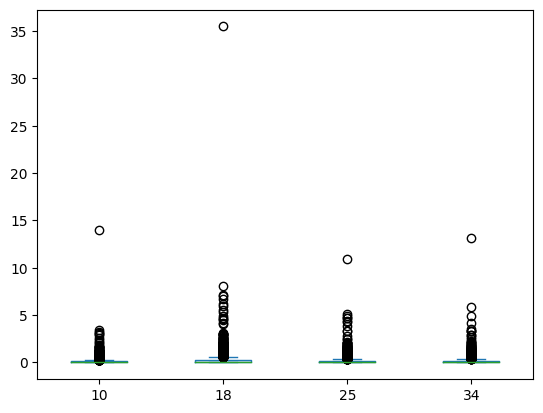

In [38]:
# Group by temperature
temp_10 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_10_" in col]].median(axis=1)
temp_18 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_18_" in col]].median(axis=1)
temp_25 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_25_" in col]].median(axis=1)
temp_34 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

In [39]:
# Which gene has very large TC values at T = 18?
# Looks like metY (MED134_00230)
df = temp_df.loc[temp_df["18"] > 5, :]
df

10         18         25         34
ID                                                      
MED134_02950   3.027189   5.950565   4.257796   2.428373
MED134_02610   2.554535   7.040867   4.723479   2.920937
MED134_02425   3.125458   7.084540   4.647675   3.342518
MED134_02420   3.178232   6.702170   4.420455   3.286673
MED134_00995   1.847643   6.191341   4.947756   2.132045
MED134_00230  13.948224  35.495446  10.971134  13.147015
MED134_07421   2.406131   5.558816   2.829529   5.837076
MED134_09116   3.403284   8.109510   5.090312   4.865490
MED134_12401   2.945541   5.299090   3.351241   2.658542

In [104]:
clust_df.loc["MED134_02950", :]

T_10    0.862633
T_18    0.610897
T_25    0.211133
T_34   -1.684664
Name: MED134_02950, dtype: float64

Text(0, 0.5, 'Total TC')

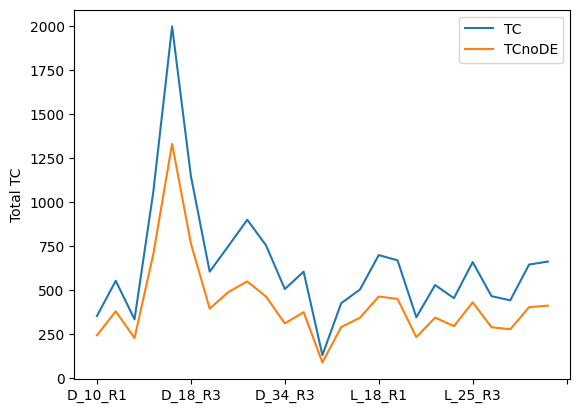

In [47]:
ax = pd.concat((TC.sum(), TCnoDE.sum()), axis=1).rename({0: "TC", 1: "TCnoDE"}, axis=1).plot()
ax.set_ylabel("Total TC")

<AxesSubplot: >

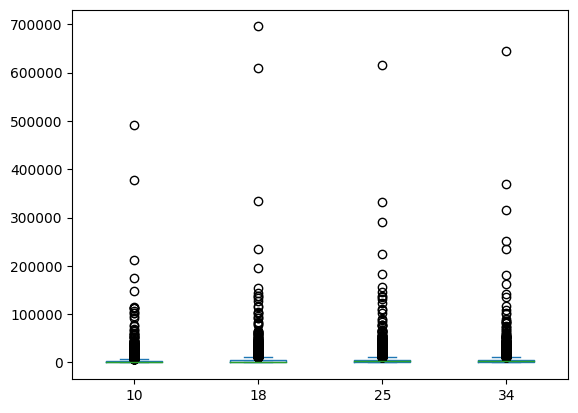

In [94]:
# Group by temperature
temp_10 = counts.loc[:, [col for col in counts.columns if "_10_" in col]].median(axis=1)
temp_18 = counts.loc[:, [col for col in counts.columns if "_18_" in col]].median(axis=1)
temp_25 = counts.loc[:, [col for col in counts.columns if "_25_" in col]].median(axis=1)
temp_34 = counts.loc[:, [col for col in counts.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

<AxesSubplot: >

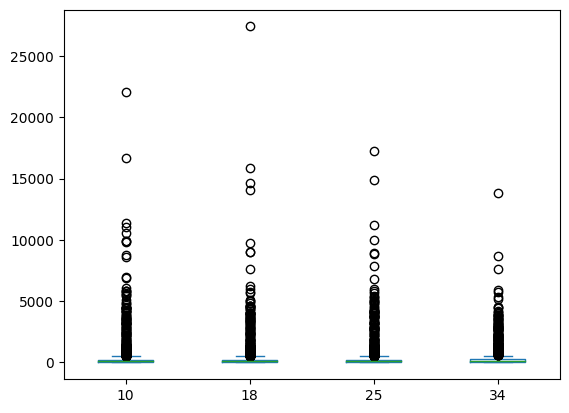

In [95]:
# Group by temperature
temp_10 = tpm.loc[:, [col for col in tpm.columns if "_10_" in col]].median(axis=1)
temp_18 = tpm.loc[:, [col for col in tpm.columns if "_18_" in col]].median(axis=1)
temp_25 = tpm.loc[:, [col for col in tpm.columns if "_25_" in col]].median(axis=1)
temp_34 = tpm.loc[:, [col for col in tpm.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

## Undo scaling by number of cells and check results

In [121]:
# Cell abundances
ca = pd.read_excel("/home/robaina/Documents/Aquifex/Dokdonia/data/Laura_Normalization/Abundancias_Dokdonia.xlsx").dropna()# Extract temperature from sample name and create a new column
ca['Temperature'] = ca['Sample'].str.extract(r'_(\d+)_', expand=False).astype(int)

# Group by temperature and compute the mean of Total_cell_abundance
mean_total_cell_abundance = ca.groupby('Temperature')['Total_cell_abundance'].mean()
print(mean_total_cell_abundance)

Temperature
10    6.244559e+08
18    3.757926e+08
25    5.002796e+08
34    5.113592e+08
Name: Total_cell_abundance, dtype: float64


In [ ]:
# Create a dictionary with Sample as key and Total_cell_abundance as value
abundance_dict = ca.set_index('Sample')['Total_cell_abundance'].to_dict()

# Multiply columns in the first DataFrame by corresponding Total_cell_abundance values
for col in TCnoDE.columns:
    if col in abundance_dict:
        TCnoDE[col] = TCnoDE[col] * abundance_dict[col]

<AxesSubplot: >

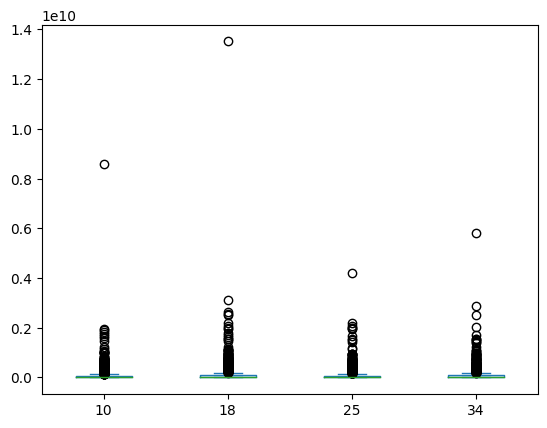

In [122]:
# Group by temperature
temp_10 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_10_" in col]].median(axis=1)
temp_18 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_18_" in col]].median(axis=1)
temp_25 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_25_" in col]].median(axis=1)
temp_34 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

# Let's now remove the scaling by internal standard

In [123]:
# Create a dictionary with Sample as key and Avg_Standard_ratio as value
avg_standard_ratio_dict = ca.set_index('Sample')['Avg_Standard_ratio'].to_dict()

# Divide columns in the first DataFrame by corresponding Avg_Standard_ratio values
for col in TCnoDE.columns:
    if col in avg_standard_ratio_dict:
        TCnoDE[col] = TCnoDE[col] / avg_standard_ratio_dict[col]

/tmp/ipykernel_70342/316247287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TCnoDE[col] = TCnoDE[col] / avg_standard_ratio_dict[col]


<AxesSubplot: >

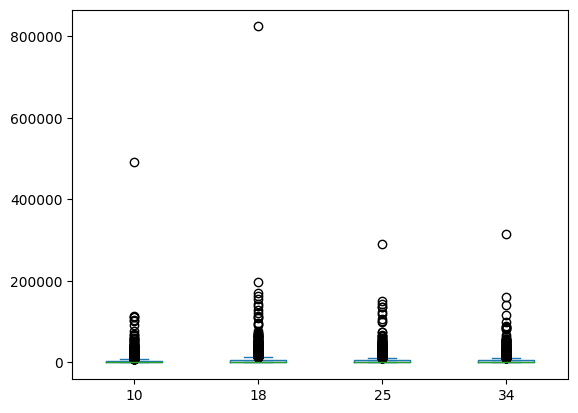

In [125]:
# Group by temperature
temp_10 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_10_" in col]].median(axis=1)
temp_18 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_18_" in col]].median(axis=1)
temp_25 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_25_" in col]].median(axis=1)
temp_34 = TCnoDE.loc[:, [col for col in TCnoDE.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

Ok, this is surprising, the pattern doesn't change much. Let's compare with counts but removing genes that are DE between light and dark.

In [51]:
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) &
    (counts["index"].isin(DE_genes_across_T))
    )]
counts_noDE.shape

(1925, 29)

<AxesSubplot: >

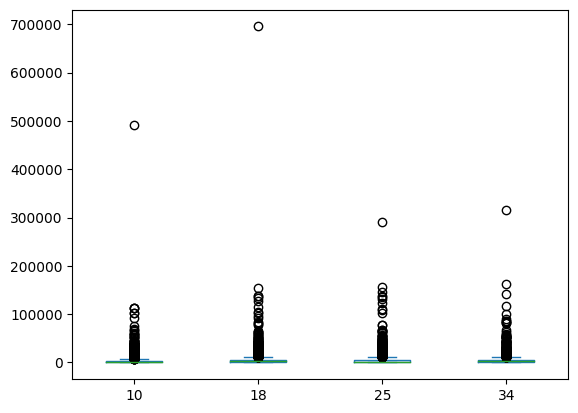

In [131]:
# Group by temperature
temp_10 = counts_noDE.loc[:, [col for col in counts_noDE.columns if "_10_" in col]].median(axis=1)
temp_18 = counts_noDE.loc[:, [col for col in counts_noDE.columns if "_18_" in col]].median(axis=1)
temp_25 = counts_noDE.loc[:, [col for col in counts_noDE.columns if "_25_" in col]].median(axis=1)
temp_34 = counts_noDE.loc[:, [col for col in counts_noDE.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

# Let's now remove DE genes between light and dark in the TPM data

<AxesSubplot: >

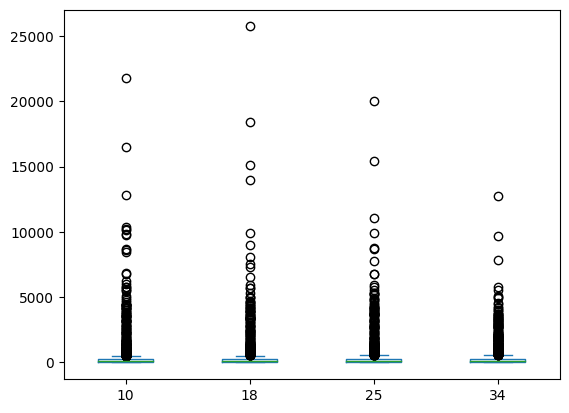

In [80]:
# Group by temperature
temp_10 = tpm_noDE.loc[:, [col for col in tpm_noDE.columns if "_10_" in col]].median(axis=1)
temp_18 = tpm_noDE.loc[:, [col for col in tpm_noDE.columns if "_18_" in col]].median(axis=1)
temp_25 = tpm_noDE.loc[:, [col for col in tpm_noDE.columns if "_25_" in col]].median(axis=1)
temp_34 = tpm_noDE.loc[:, [col for col in tpm_noDE.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

Text(0, 0.5, 'Total TPM')

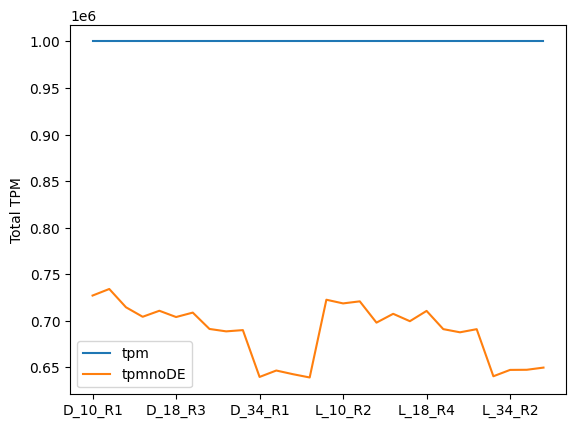

In [108]:
# Total TPM sum per sample
ax = pd.concat((tpm.sum(axis=0),tpm_noDE.sum(axis=0)), axis=1).rename({0: "tpm", 1: "tpmnoDE"}, axis=1).plot()
ax.set_ylabel("Total TPM")

Text(0, 0.5, 'Total counts')

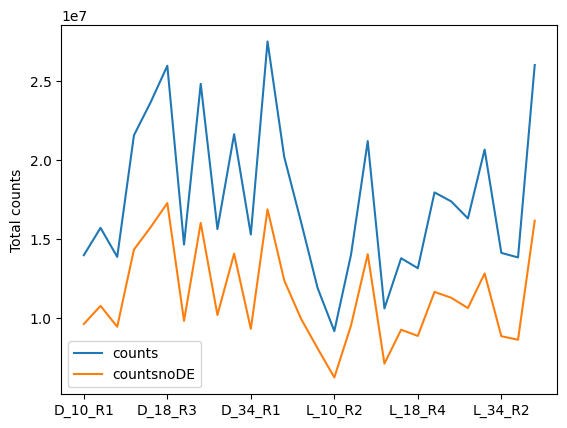

In [82]:
# Total counts sum per sample
ax = pd.concat((counts.set_index("index").sum(),counts_noDE.set_index("index").sum()), axis=1).rename({0: "counts", 1: "countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total counts")

## Alright, let's now apply deseq2 normalization to counts

In [83]:
# Apply Deseq2
from diffexpr.py_deseq import py_DESeq2
def deseq2Normalize(counts, coldata, gene_column="gene_id", design_formula="~ 1"):
    """
    Run deseq2
    """
    dds = py_DESeq2(
        count_matrix=counts,
        design_matrix=coldata,
        design_formula=design_formula,
        gene_column=gene_column,
    )
    dds.run_deseq()
    deseq2_counts = dds.normalized_count()
    return deseq2_counts


colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

Temperature
Sample             
D_10_R1          10
D_10_R2          10
D_10_R3          10
D_18_R1          18
D_18_R2          18

In [88]:
deseq2_counts = deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")


deseq2_counts_noDE = deseq2_counts.loc[(
    (~deseq2_counts.index.isin(DE_all_T)) &
    (deseq2_counts.index.isin(DE_genes_across_T))
    )].drop("index", axis=1)
deseq2_counts.head()

INFO:DESeq2:Normalizing counts


D_10_R1       D_10_R2       D_10_R3       D_18_R1  \
MED134_07389  17200.328111  14079.549534  17542.778048  25860.344831   
MED134_07384   2064.357579   1916.129838   2054.666933   3512.899507   
MED134_07379   4507.909934   4089.797383   4333.070149   6095.218423   
MED134_07374   2634.475600   2617.273167   1858.732200   2963.164512   
MED134_07369   2767.061186   2476.798054   2794.717716   3186.942966   

                   D_18_R2       D_18_R3       D_18_R4       D_25_R1  \
MED134_07389  23367.283776  28332.464815  26700.509130  37207.448071   
MED134_07384   3346.578462   3860.189530   3496.792590   5217.612053   
MED134_07379   6031.473110   6589.539715   5994.501582   9169.175725   
MED134_07374   2878.744347   2995.998925   3094.780380   3183.779964   
MED134_07369   2906.982295   3098.928102   3450.406565   3225.935505   

                   D_25_R2       D_25_R3  ...       L_18_R3       L_18_R4  \
MED134_07389  33522.925070  29261.605228  ...  28608.677162  26107.530428   
MED134_07384   4669.741702   4031.808830  ...   3587.882962   3758.590840   
MED134_07379   7841.934834   7857.009594  ...   6405.141711   6393.760437   
MED134_07374   3434.212349   3228.988917  ...   3056.211993   3424.811349   
MED134_07369   3579.203220   2924.242019  ...   4129.112060   3906.648668   

                   L_25_R1       L_25_R2       L_25_R3       L_34_R1  \
MED134_07389  37356.607102  40340.607385  36473.898882  29607.298508   
MED134_07384   5132.224264   5352.834364   5239.551439   4028.061690   
MED134_07379   8608.006337   8717.694115   8403.184321   7598.524823   
MED134_07374   3396.227387   3475.087916   3436.546713   3103.906691   
MED134_07369   3508.929858   4020.427255   3704.534300   4119.133507   

                   L_34_R2       L_34_R3       L_34_R4         index  
MED134_07389  32446.920915  30009.959419  34346.796127  MED134_07389  
MED134_07384   4975.480788   4713.807775   4642.999829  MED134_07384  
MED134_07379   7976.896899   7928.217651   8211.660097  MED134_07379  
MED134_07374   3242.283418   2885.488400   3161.254552  MED134_07374  
MED134_07369   3731.348779   2984.494864   3058.512295  MED134_07369  

[5 rows x 29 columns]

/tmp/ipykernel_30974/221219321.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = pd.concat((deseq2_counts.mean(axis=0),deseq2_counts_noDE.mean(axis=0)), axis=1).rename({0: "deseq2_counts", 1: "deseq2_countsnoDE"}, axis=1).plot()


Text(0, 0.5, 'Total deseq2 counts')

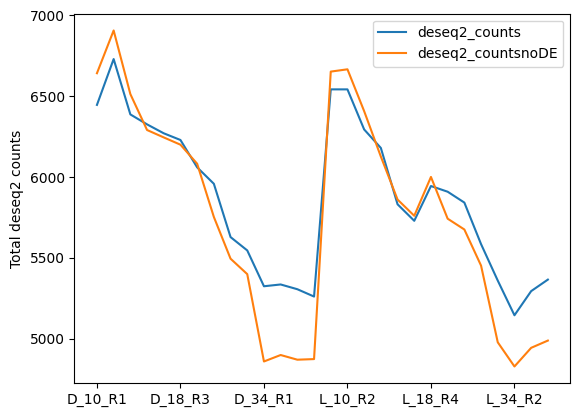

In [103]:
# Total deseq2 counts sum per sample
ax = pd.concat((deseq2_counts.mean(axis=0),deseq2_counts_noDE.mean(axis=0)), axis=1).rename({0: "deseq2_counts", 1: "deseq2_countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total deseq2 counts")

Text(0, 0.5, 'Total deseq2 counts')

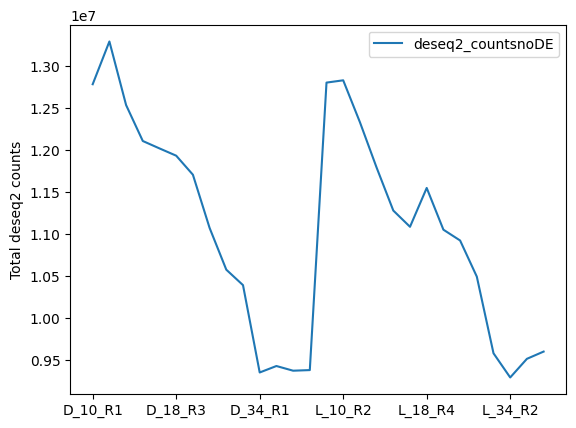

In [102]:
# Total deseq2 counts sum per sample
ax = pd.concat((deseq2_counts.sum(),deseq2_counts_noDE.sum()), axis=1).rename({0: "deseq2_counts", 1: "deseq2_countsnoDE"}, axis=1).plot()
ax.set_ylabel("Total deseq2 counts")

<AxesSubplot: >

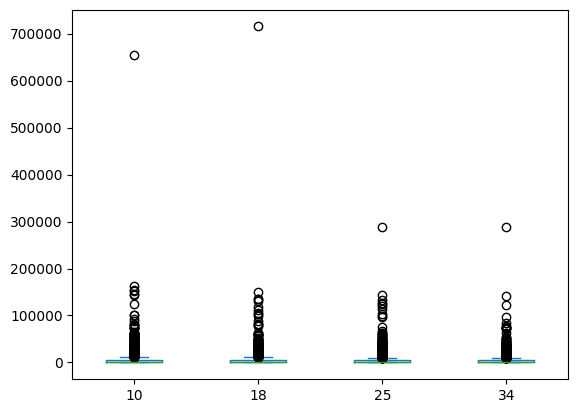

In [158]:
# Group by temperature
temp_10 = deseq2_counts.loc[:, [col for col in deseq2_counts.columns if "_10_" in col]].median(axis=1)
temp_18 = deseq2_counts.loc[:, [col for col in deseq2_counts.columns if "_18_" in col]].median(axis=1)
temp_25 = deseq2_counts.loc[:, [col for col in deseq2_counts.columns if "_25_" in col]].median(axis=1)
temp_34 = deseq2_counts.loc[:, [col for col in deseq2_counts.columns if "_34_" in col]].median(axis=1)

# Merge into one dataframe
temp_df = pd.concat([temp_10, temp_18, temp_25, temp_34], axis=1)
temp_df.columns = ["10", "18", "25", "34"]

# Plot
temp_df.plot.box(legend=False)

## Run Clust on deseq2 counts


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Friday 14 April 2023 (14:44:42)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

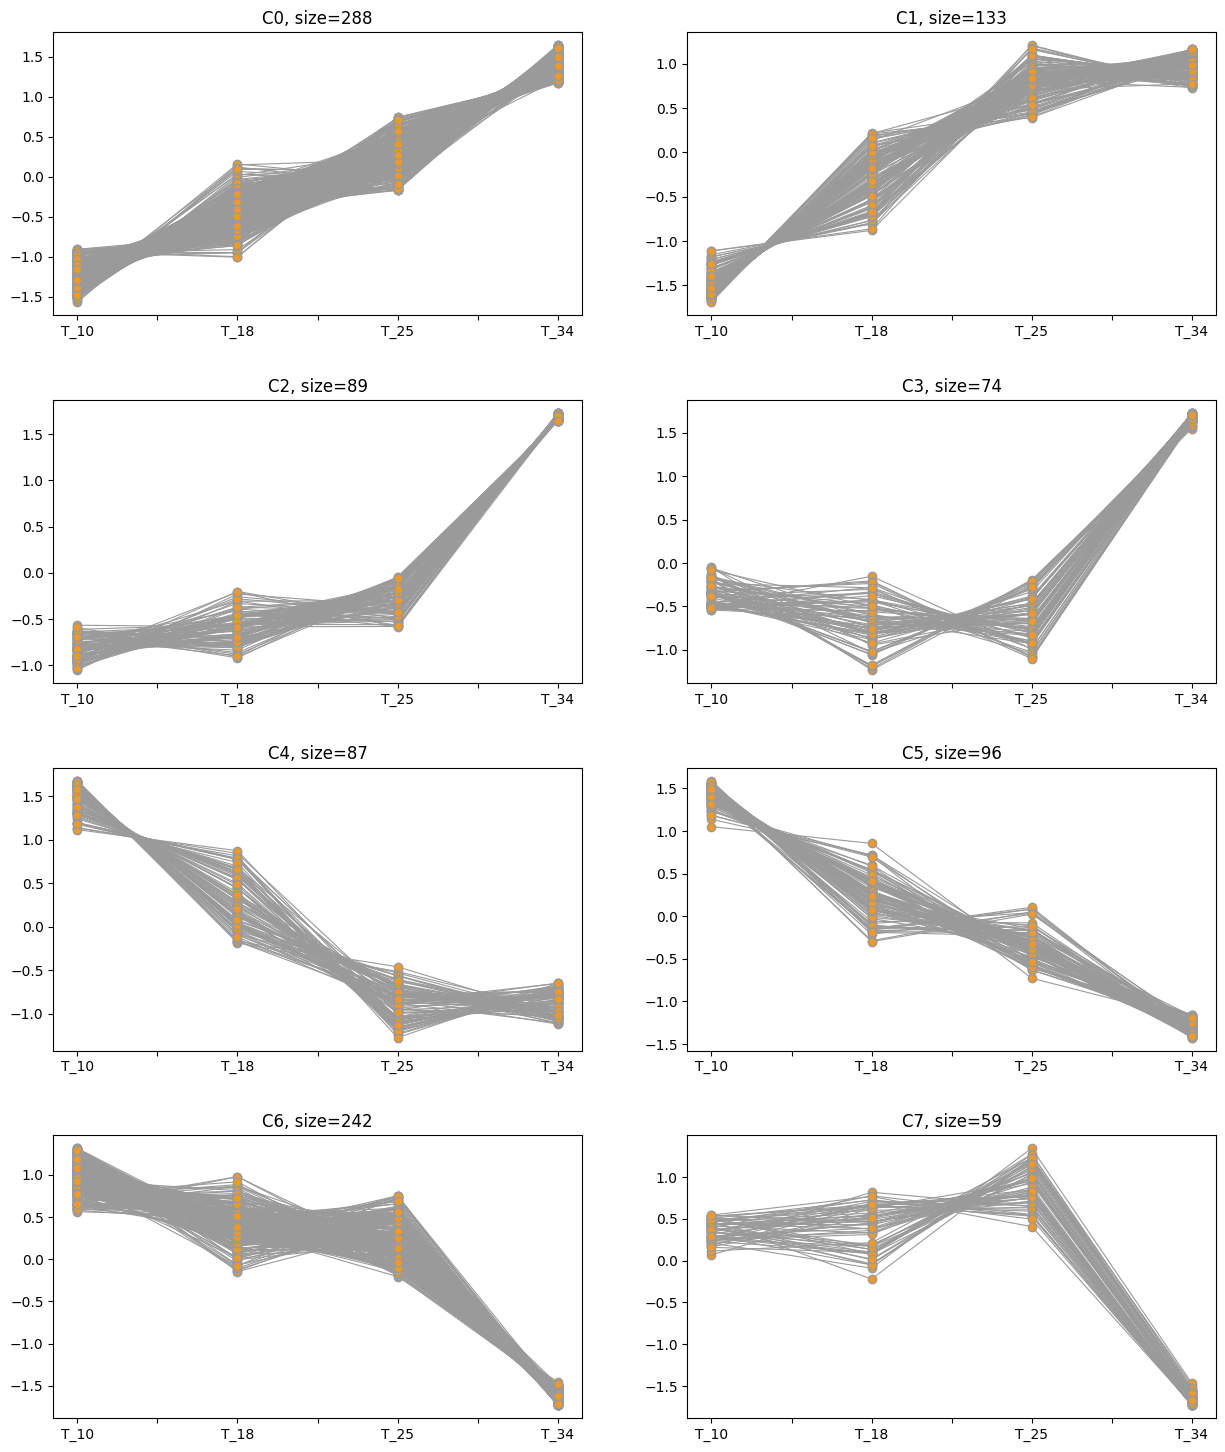

In [183]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_DESEQ2'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters = CA.getGeneClusters(deseq2_counts, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file="clust_normalization.txt",
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters)

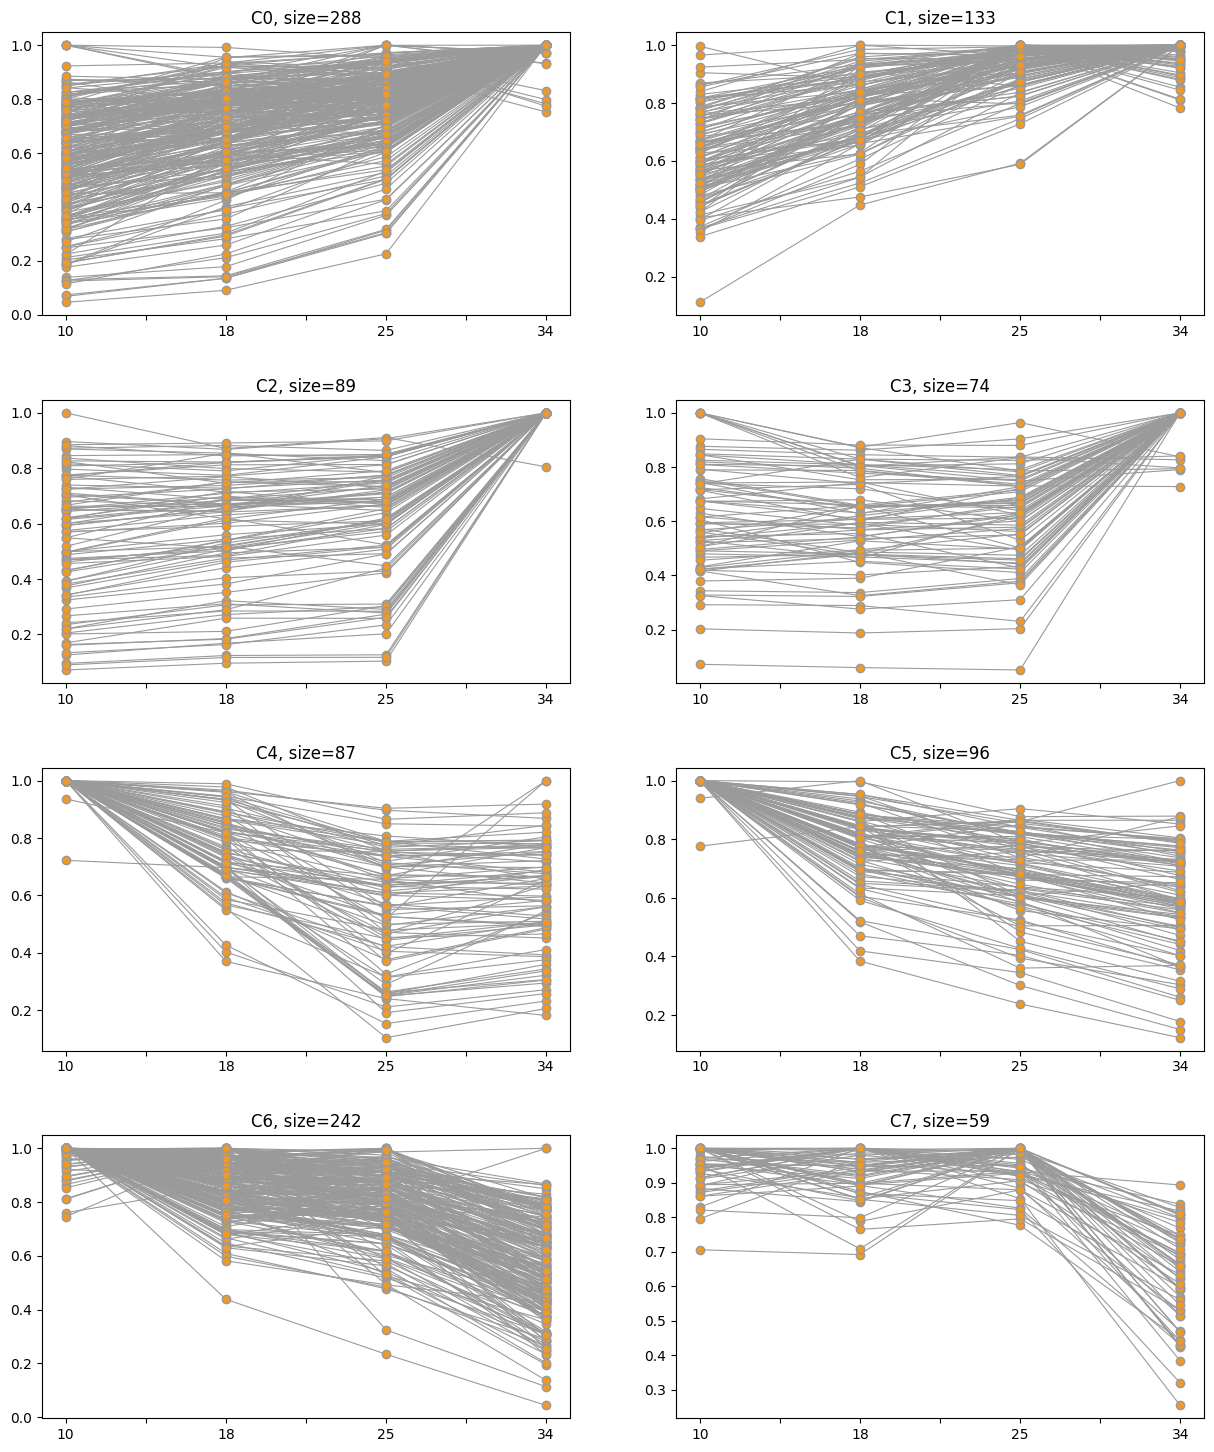

In [184]:
# Group by temperature
def groupDataByTemperature(
    data: pd.DataFrame, statistic="mean", normalize=True
) -> pd.DataFrame:
    """
    Group data by temperature
    """
    if statistic == "mean":
        data = data.groupby(
            data.columns.str.extract(r"_(\d+)_", expand=False), axis=1
        ).mean()
    elif statistic == "median":
        data = data.groupby(
            data.columns.str.extract(r"_(\d+)_", expand=False), axis=1
        ).median()
    else:
        raise ValueError(f"Unknown statistic: {statistic}")
    if normalize:
        data = data.div(data.max(axis=1), axis=0)
    return data

plot_cluster_data = groupDataByTemperature(
    deseq2_counts, statistic="median", normalize=True
    )

VI.plotClusters(plot_cluster_data, clusters)

# Run Clust on TPM with DE genes removed


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Friday 14 April 2023 (14:43:34)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

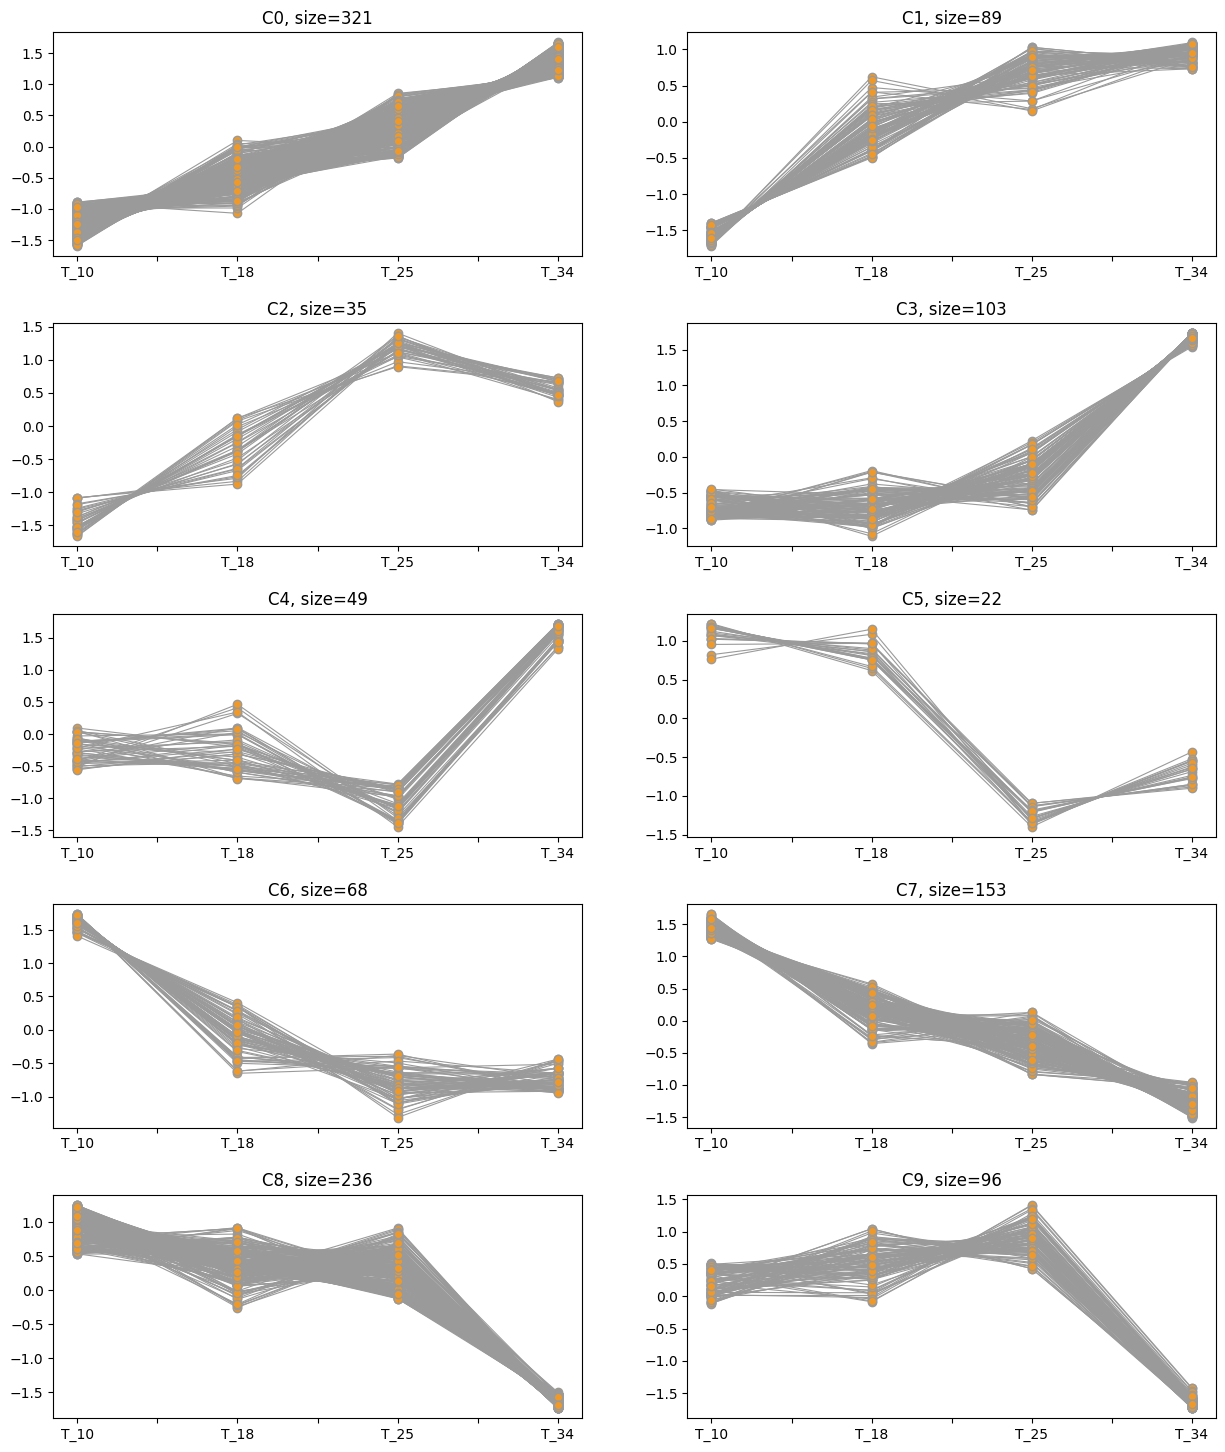

In [181]:
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TPM'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters = CA.getGeneClusters(tpm_noDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file="clust_normalization.txt",
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters)

## Plot input data

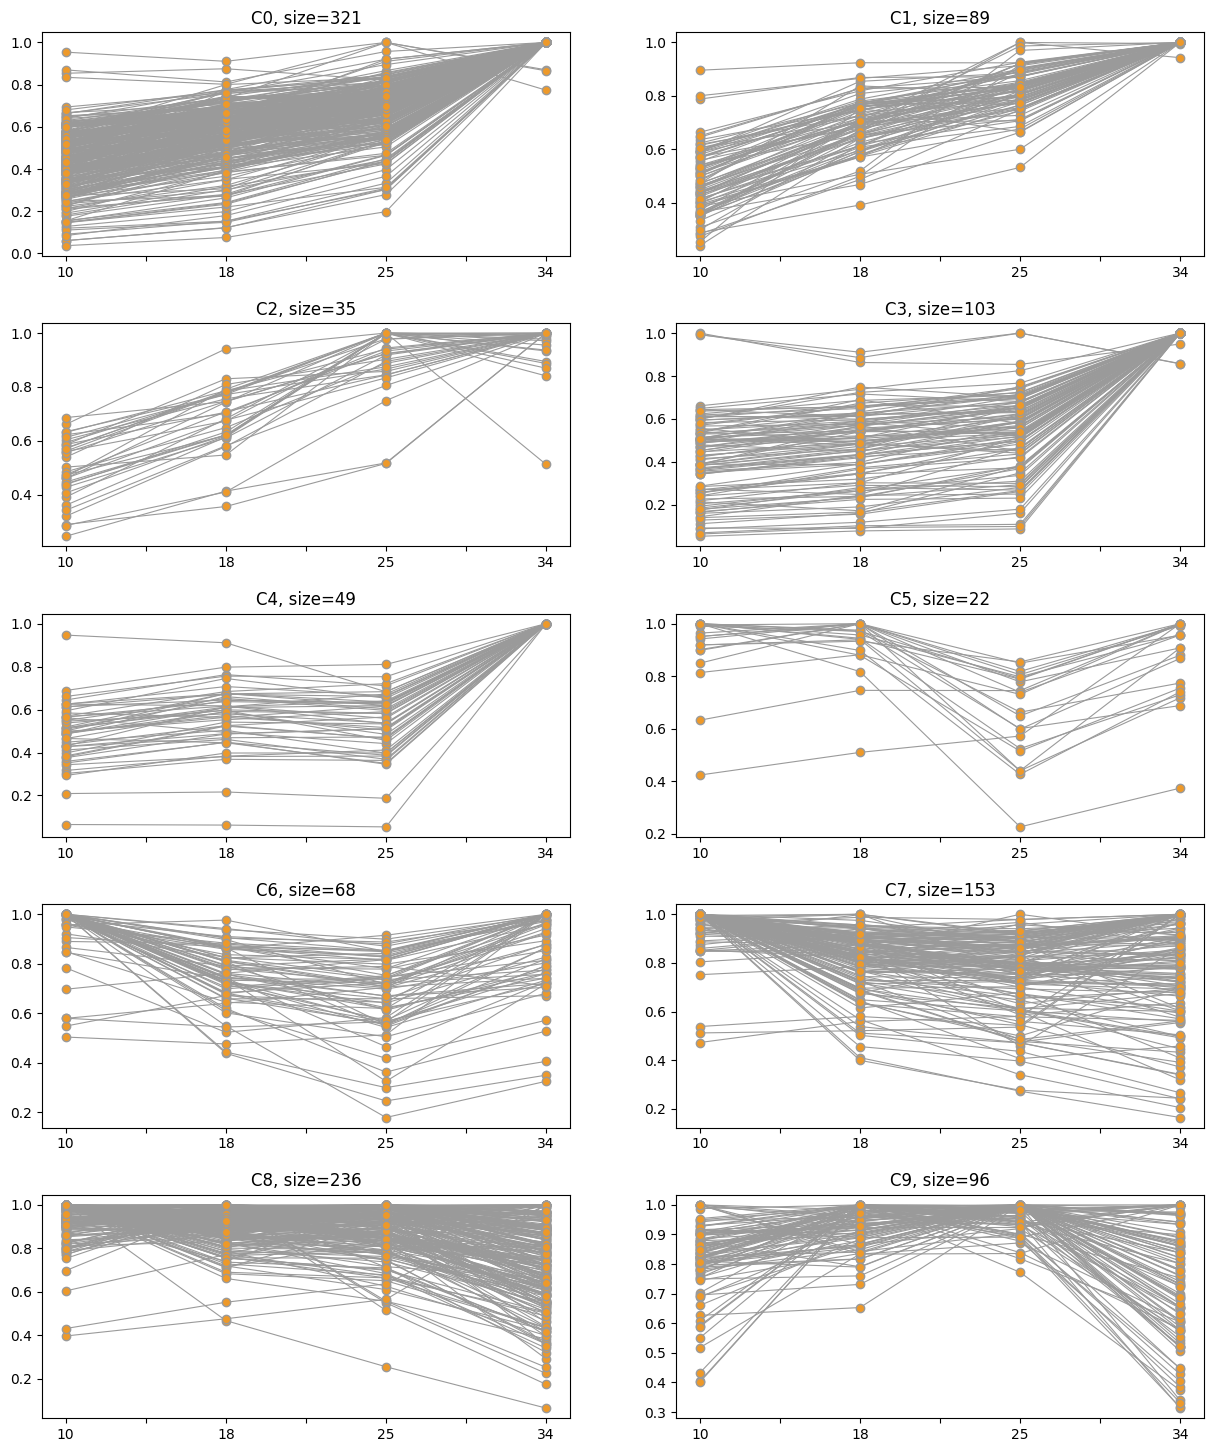

In [182]:
plot_cluster_data = groupDataByTemperature(
    tpm_noDE, statistic="median", normalize=True
    )

VI.plotClusters(plot_cluster_data, clusters)

## Ok not so bad before, let's try again with transcript / cell


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Friday 14 April 2023 (14:49:40)                      |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

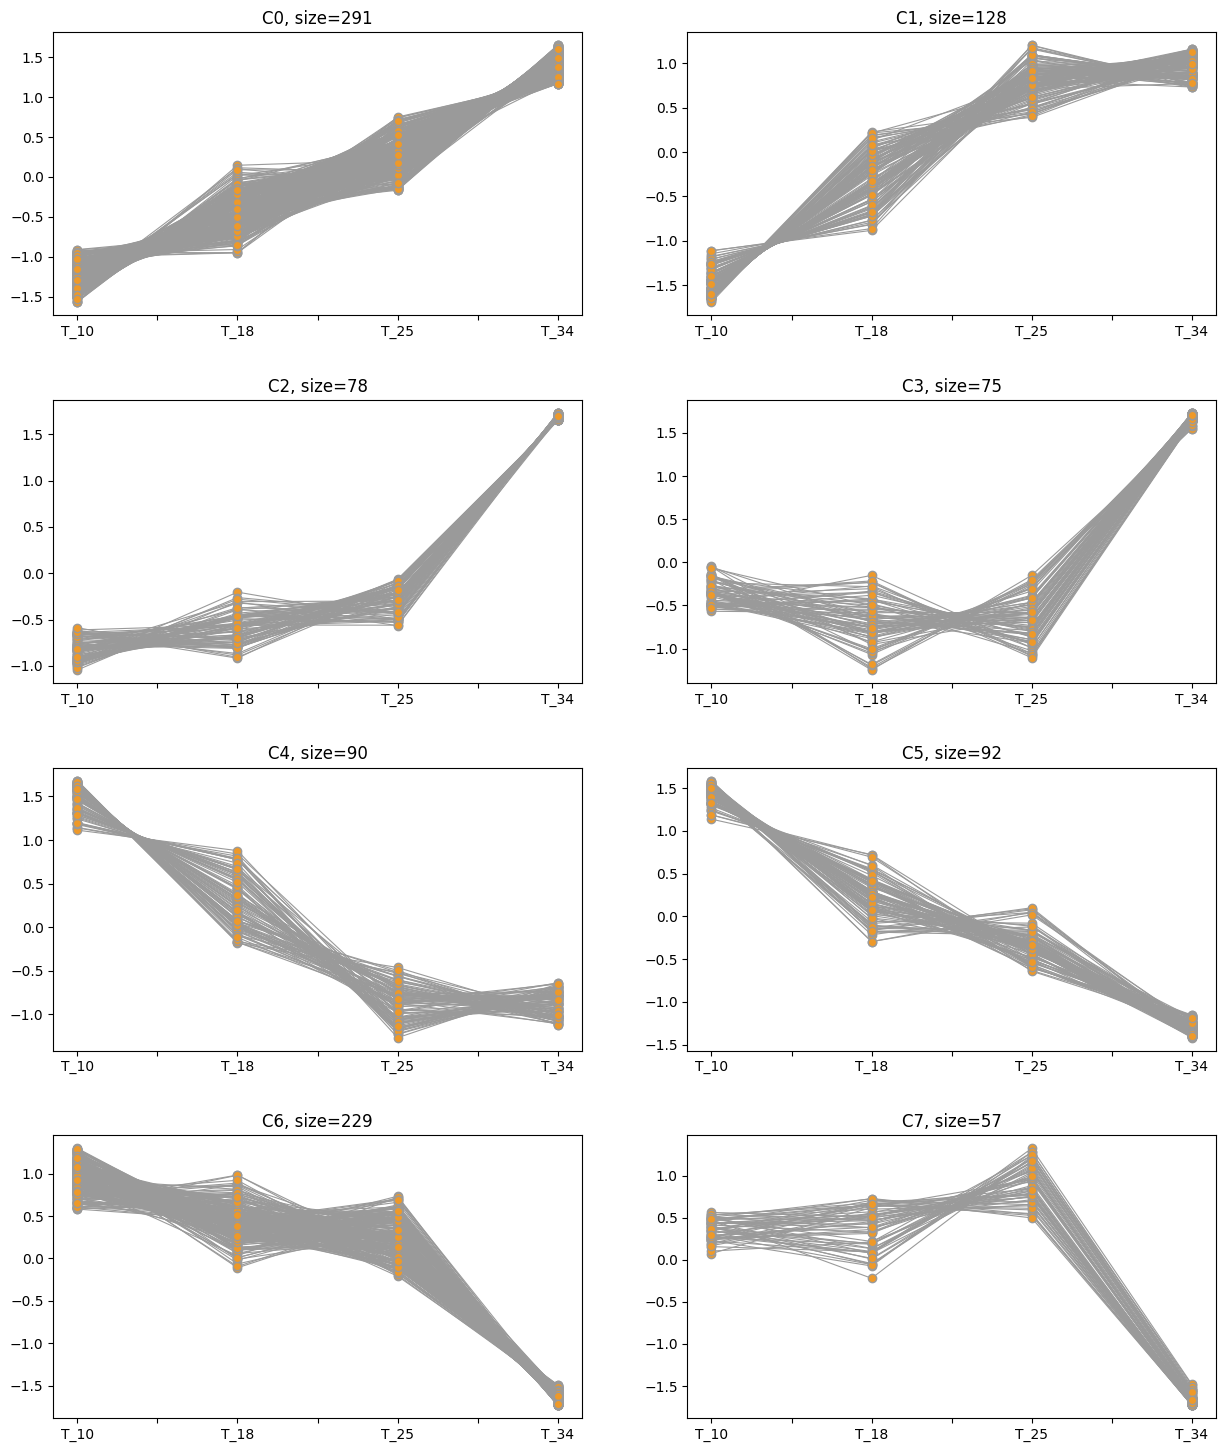

In [186]:
clust_tightness = 3
res_id = "CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_CELL"
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file="clust_normalization.txt",
                              replicates_file='clust_replicates_merged_L_D.txt',
                              scaling_factor=1)

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters)

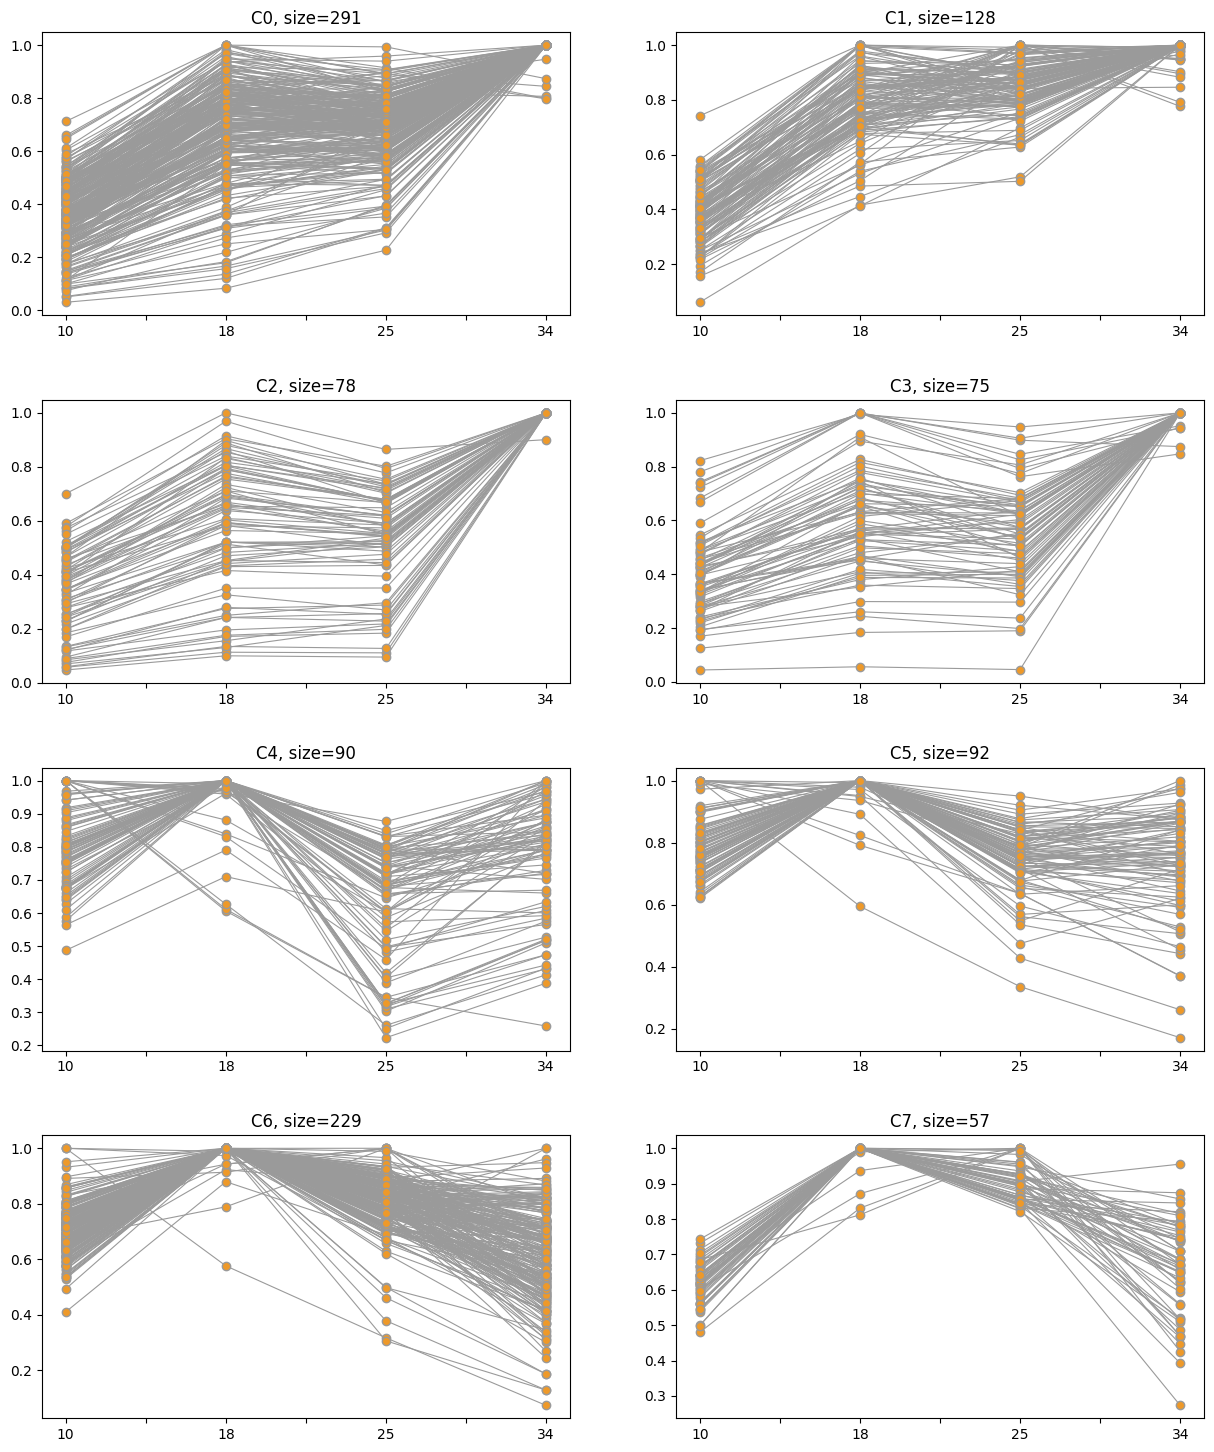

In [187]:
# Original data
plot_cluster_data = groupDataByTemperature(
    TCnoDE, statistic="median", normalize=True
    )

VI.plotClusters(plot_cluster_data, clusters)

# Plot gene average expression across temperatures

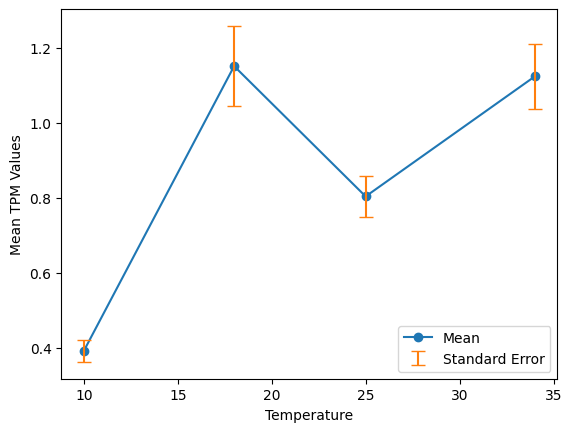

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


temperatures = [10, 18, 25, 34]
marker_genes = [
    gene_id_product[0]
    for gene_id_product in cluster_marker_genes["C0"]
    ]
df = TCnoDE.loc[marker_genes, :]


df_long = df.melt(var_name='Column', value_name='Value')
df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

grouped = df_long.groupby('Temperature')['Value']
mean_values = grouped.mean()
standard_error_values = grouped.sem()


fig, ax = plt.subplots()

# Plot the mean values
ax.plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

# Add error bars for the standard errors
ax.errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Mean TPM Values')
# ax.set_title('Mean Values with Standard Error across Temperature Values')
ax.legend()

# Show the plot
plt.show()

# Plotting a single gene (pandas series)


Condition: D_18_R2 looks like an outlier.

In [80]:
grouped.mean()

Temperature
10    0.054660
18    0.094259
25    0.042165
34    0.054863
Name: Value, dtype: float64

<AxesSubplot: >

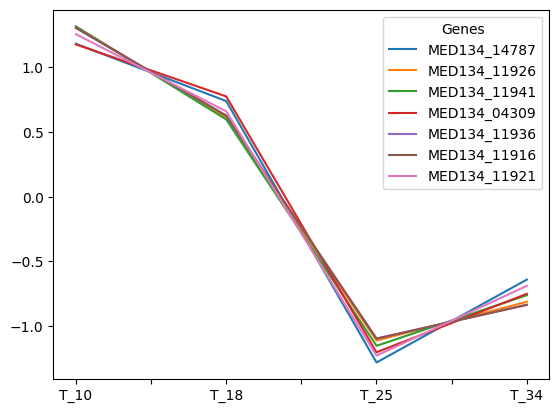

In [87]:
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

cluster_data.loc[marker_genes, :].transpose().plot()

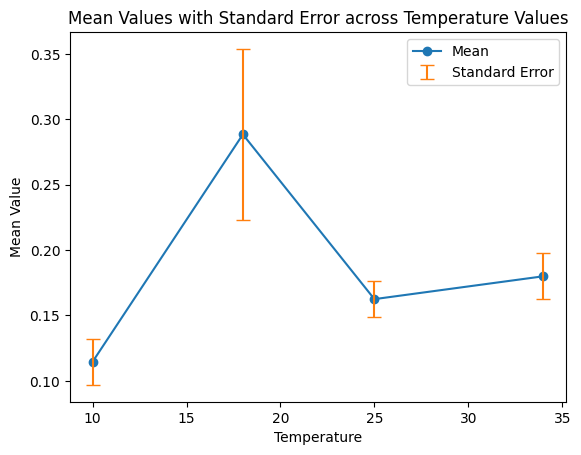

In [74]:
s = TC.loc[marker_genes[0], :]
df = s.to_frame(name='Value').reset_index()

df = df.rename(columns={'index': 'Column'})
df['Temperature'] = df['Column'].str.extract('_(\d+)_')

df['Temperature'] = pd.to_numeric(df['Temperature'])

grouped = df.groupby('Temperature')['Value']
mean_values = grouped.mean()
standard_error_values = grouped.sem()


# Plot
fig, ax = plt.subplots()

# Plot the mean values
ax.plot(mean_values.index, mean_values, marker='o', linestyle='-', label='Mean')

# Add error bars for the standard errors
ax.errorbar(mean_values.index, mean_values, yerr=standard_error_values, linestyle='', capsize=5, label='Standard Error')

# Customize the plot
ax.set_xlabel('Temperature')
ax.set_ylabel('Mean Value')
ax.set_title('Mean Values with Standard Error across Temperature Values')
ax.legend()

# Show the plot
plt.show()


# Describing ranked genes

In [53]:
no_kegg_pathway = []
for cluster_id in ranked_clusters_avg_expr:
    ranked_df = show_pathways_in_ranked_genes(
        ranked_clusters_avg_expr[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}.csv")

print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[79.33333333333333, 82.95454545454545, 83.22147651006712, 68.25938566552901, 79.5275590551181, 79.34782608695652]
78.77402101759158


# Ranked lists among the global 10% by expression

In [51]:
percent_cutoff = 10

filtered_ranked_clusters = {}

all_genes_expression = {gene: expr for cluster in ranked_clusters_avg_expr.values() for gene, expr in cluster.items()}

sorted_all_genes_expression = sorted(all_genes_expression.items(), key=lambda x:x[1], reverse=True)
sorted_all_genes_expression = dict(sorted_all_genes_expression)

cutoff_position = int( (10 / 100) * len(sorted_all_genes_expression) )
cutoff_value = list(sorted_all_genes_expression.values())[cutoff_position]
print(f"Cutoff average expression value of: {cutoff_value} transcript/cell")
top_genes = list(sorted_all_genes_expression.keys())[:cutoff_position]

for cluster_id, cluster in ranked_clusters_avg_expr.items():
    filtered_ranked_clusters[cluster_id] = {gene: expr for gene, expr in cluster.items() if gene in top_genes}

Cutoff average expression value of: 0.3841299631613423 transcript/cell


In [52]:
no_kegg_pathway = []
for cluster_id in filtered_ranked_clusters:
    ranked_df = show_pathways_in_ranked_genes(
        filtered_ranked_clusters[cluster_id],
        gbk, gene_pathways,
        gene_systems, n=None
        )
    no_kegg_pathway.append( 100 * (ranked_df[((ranked_df.subsystem.str.contains("Unspecified")) & ~ ranked_df.subsystem.isna())].shape[0]) / ranked_df.shape[0] )
    # ranked_df = ranked_df[~(
    #     (ranked_df["product"].str.contains("hypothetical")) &
    #     (ranked_df["subsystem"].str.contains("Unspecified"))
    #     )]
    ranked_df.to_csv(results_dir / "pathways" / f"ranked_{cluster_id}_top_10_pct.csv")

print(no_kegg_pathway)
print(np.mean(no_kegg_pathway))

[61.76470588235294, 100.0, 50.0, 36.734693877551024, 87.5, 100.0]
72.66656662665066
